In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append("../")
from PREDICT import PREDICT
from PREDICT.Models import BayesianModel
from PREDICT.Metrics import *
from PREDICT.Triggers import BayesianRefitTrigger
from PREDICT.Plots import *


%matplotlib inline
import pandas as pd
import numpy as np

import arviz as az
import matplotlib.pyplot as plt
import datetime as dt

import pymc as pm
from pymc import Model, Normal, sample, math, Bernoulli
from statsmodels.formula.api import logit
from scipy.special import expit
import bambi as bmb
import bambi.priors as priors

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

RANDOM_SEED = 1
rng = np.random.default_rng(RANDOM_SEED)

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


### Create some fake COVID data

In [2]:
mydict = {
    'date': list(),
    'outcome': list(),
    'prediction': list(),
    'age': list(),
    'systolic_bp': list(),
    'flu_symptoms': list()
}

# Set random seed for reproducibility
np.random.seed(42)

records_per_day = 30

# Define date range and COVID shock periods
startDate = pd.to_datetime('01-09-2021', dayfirst=True)  # Start a year before COVID
endDate = pd.to_datetime('31-12-2021', dayfirst=True)  # Include recovery period after COVID
switchDate = pd.to_datetime('01-03-2020', dayfirst=True)  # COVID starts spreading
switchDate2 = pd.to_datetime('01-06-2020', dayfirst=True)  # Peak of the pandemic
recoveryDate = pd.to_datetime('01-06-2021', dayfirst=True)  # Start of recovery phase
numdays = (endDate - startDate).days
switchDays = (switchDate - startDate).days
switch2Days = (switchDate2 - startDate).days
recoveryDays = (recoveryDate - startDate).days

for i in range(numdays):
    curday = startDate + dt.timedelta(days=i)

    age = np.random.normal(70, 5, records_per_day)  # Mean age 70 years, std 5
    systolic_bp = np.random.normal(120, 20, records_per_day)  # Mean systolic blood pressure 120 mmHg, std 10

    # Calculate baseline log-odds
    lp = -1.5 + 0.5 * (age - 70) / 5 + 2 * (systolic_bp - 120) / 10
    curpredictions = 1 / (1 + np.exp(-lp))  # Convert to probability

    # Simulate COVID effects
    if switchDays <= i < switch2Days:
        lp += 1.5  # Initial impact of COVID
    elif switch2Days <= i < recoveryDays:
        lp += 2.0  # Peak of the pandemic
    elif i >= recoveryDays:
        lp -= 1.0  # Recovery period—improved health outcomes

    # Simulate flu symptoms
    if i < switchDays:
        flu_symptoms = np.random.binomial(1, 0.1, records_per_day)  # Low baseline prevalence
    elif i < switch2Days:
        flu_symptoms = np.random.binomial(1, 0.3, records_per_day)  # Increased prevalence during COVID spread
    elif i < recoveryDays:
        flu_symptoms = np.random.binomial(1, 0.5, records_per_day)  # Higher prevalence during pandemic peak
    else:
        flu_symptoms = np.random.binomial(1, 0.2, records_per_day)  # Reduced prevalence during recovery

    # Generate outcomes
    curoutcomes = np.random.binomial(1, 1 / (1 + np.exp(-lp)))  # Simulate "heart attack" events

    # Append to dictionary
    mydict['date'].extend([curday] * records_per_day)
    mydict['outcome'].extend(curoutcomes)
    mydict['prediction'].extend(curpredictions)
    mydict['age'].extend(age)
    mydict['systolic_bp'].extend(systolic_bp)
    mydict['flu_symptoms'].extend(flu_symptoms)

df = pd.DataFrame(mydict)

df.head()

,date,outcome,prediction,age,systolic_bp,flu_symptoms
0,2021-08-01,0,0.025124,72.483571,107.965868,0
1,2021-08-01,1,0.997100,69.308678,157.045564,0
2,2021-08-01,0,0.226156,73.238443,119.730056,0
3,2021-08-01,0,0.006900,77.615149,98.845781,0
4,2021-08-01,0,0.841989,68.829233,136.450898,0


In [3]:
len(df)

4560

Modeling the probability that outcome==1


{'Intercept': None, 'age': None, 'systolic_bp': None}
{'Intercept': None, 'age': None, 'systolic_bp': None}
Optimization terminated successfully.
         Current function value: 0.243833
         Iterations 9

*** PRIORS ***
Intercept mean coef:  -34.67 ± 3.20
age mean coef:  0.10 ± 0.03
systolic_bp mean coef:  0.21 ± 0.02


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, age, systolic_bp]


Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 151 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Modeling the probability that outcome==1



*** POSTERIORS ***
Intercept mean coef: -68.41 ± 35.84
age mean coef: 0.12 ± 0.03
systolic_bp mean coef: 0.43 ± 0.23
{'Intercept': (np.float64(-68.40689868500192), np.float64(35.83824074331071)), 'age': (np.float64(0.1242956042900033), np.float64(0.03166208099311493)), 'systolic_bp': (np.float64(0.4288050855369103), np.float64(0.23194662659133722))}

*** PRIORS ***
Intercept mean coef: -68.41 ± 35.84
age mean coef: 0.12 ± 0.03
systolic_bp mean coef: 0.43 ± 0.23


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, age, systolic_bp]


Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 215 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Modeling the probability that outcome==1



*** POSTERIORS ***
Intercept mean coef: -198.27 ± 133.42
age mean coef: 0.20 ± 0.05
systolic_bp mean coef: 1.37 ± 0.97
{'Intercept': (np.float64(-198.26606180602732), np.float64(133.42247640658007)), 'age': (np.float64(0.19711212044668452), np.float64(0.049301867268730294)), 'systolic_bp': (np.float64(1.3739476787448834), np.float64(0.9740253514625693))}

*** PRIORS ***
Intercept mean coef: -198.27 ± 133.42
age mean coef: 0.20 ± 0.05
systolic_bp mean coef: 1.37 ± 0.97


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, age, systolic_bp]


Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 2880 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details



*** POSTERIORS ***
Intercept mean coef: -2603.55 ± 1202.32
age mean coef: 0.39 ± 0.06
systolic_bp mean coef: 20.08 ± 9.83


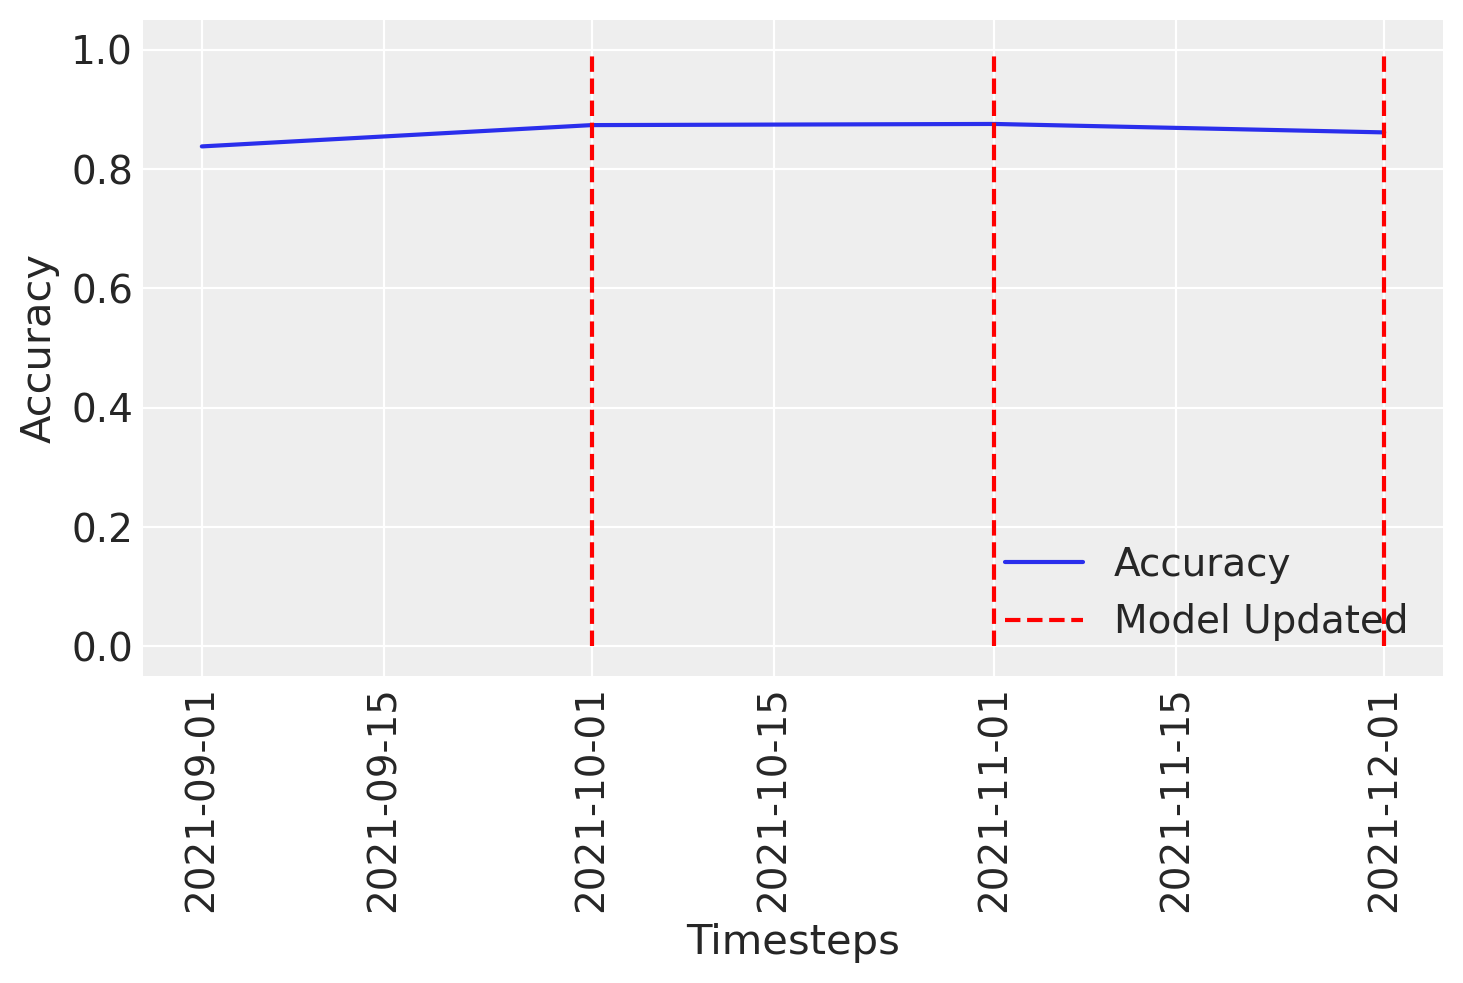

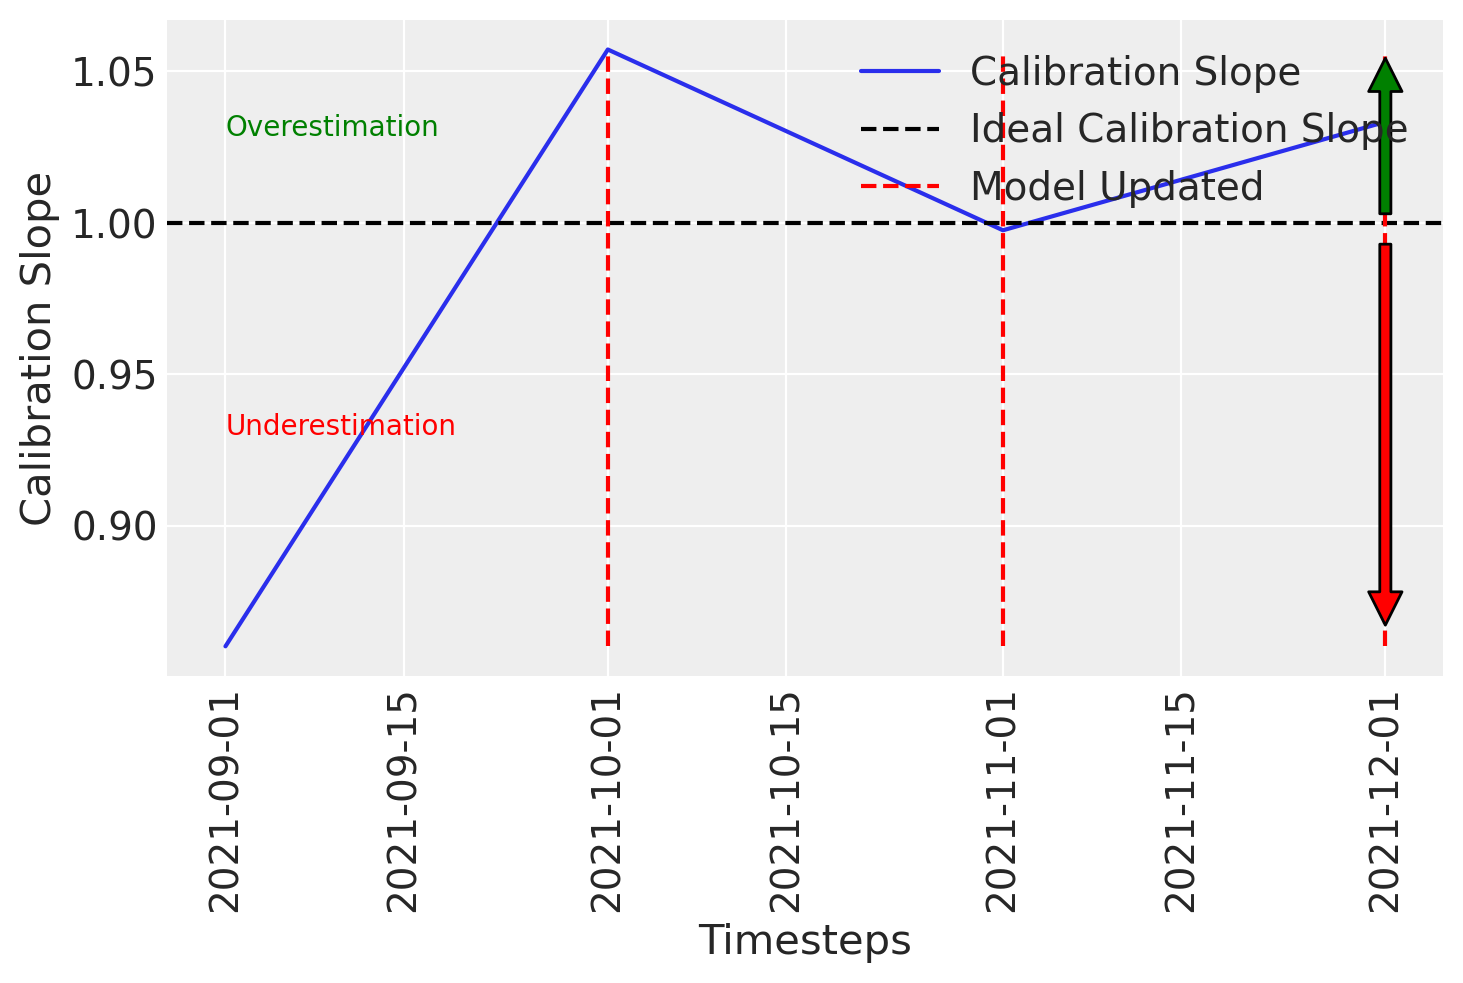

In [4]:
predictors = ['age', 'systolic_bp']
model = BayesianModel(priors={"Intercept": (None), "age": (None), "systolic_bp": (None)})
model.trigger = BayesianRefitTrigger(model=model, input_data=df, refitFrequency=1)

mytest = PREDICT(data=df, model=model, startDate='min', endDate='max', timestep='month')
mytest.addLogHook(Accuracy(model))
mytest.addLogHook(CalibrationSlope(model))
mytest.addLogHook(CITL(model))
mytest.addLogHook(TrackBayesianCoefs(model))
mytest.run()
log = mytest.getLog()
AccuracyPlot(log)
CalibrationSlopePlot(log)

In [15]:
log['BayesianCoefficients']

{Timestamp('2021-09-01 00:00:00'): {'Intercept': None,
  'age': None,
  'systolic_bp': None},
 Timestamp('2021-10-01 00:00:00'): {'Intercept': None,
  'age': None,
  'systolic_bp': None},
 Timestamp('2021-11-01 00:00:00'): {'Intercept': (np.float64(-68.40689868500192),
   np.float64(35.83824074331071)),
  'age': (np.float64(0.1242956042900033), np.float64(0.03166208099311493)),
  'systolic_bp': (np.float64(0.4288050855369103),
   np.float64(0.23194662659133722))},
 Timestamp('2021-12-01 00:00:00'): {'Intercept': (np.float64(-198.26606180602732),
   np.float64(133.42247640658007)),
  'age': (np.float64(0.19711212044668452), np.float64(0.049301867268730294)),
  'systolic_bp': (np.float64(1.3739476787448834),
   np.float64(0.9740253514625693))}}

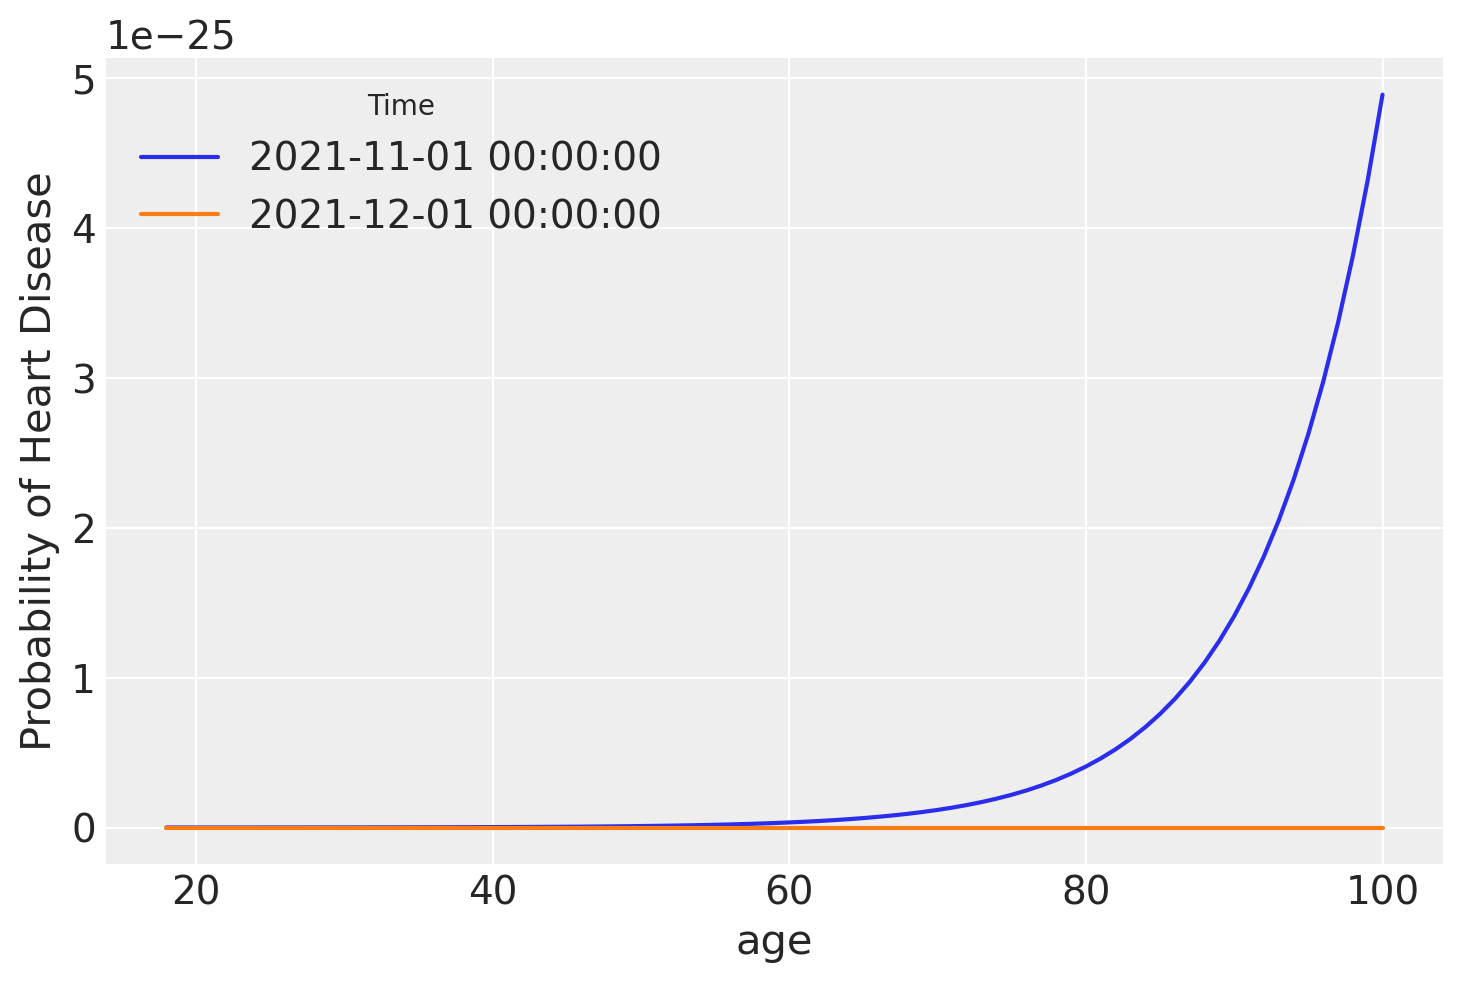

In [14]:
ProbOverTimePlot(log, x_axis_min = 18, x_axis_max=100, predictor="age", outcome="Heart Disease")

In [7]:
# # To grab semi-realistic priors
# faux_model = logit("outcome ~ age + systolic_bp", data=df).fit()
# print(faux_model.summary())

In [8]:
# custom_priors = {
#         faux_model.params.index[0]: bmb.Prior("Normal", mu=faux_model.params[0], sigma=faux_model.bse[0]),  # Prior for the intercept
#         faux_model.params.index[1]: bmb.Prior("Normal", mu=faux_model.params[1], sigma=faux_model.bse[1]),  
#         faux_model.params.index[2]: bmb.Prior("Normal", mu=faux_model.params[2], sigma=faux_model.bse[2])
#     }

# model = bmb.Model("outcome ~ age + systolic_bp", data=df, family="bernoulli", priors=custom_priors)
# bambi_idata = model.fit(draws=100, tune=100, cores=12, chains=4)


In [9]:
#az.plot_trace(bambi_idata, figsize=(10, 7), );

In [10]:
# posterior_samples = bambi_idata.posterior


# print("\n*** PRIORS ***")
# print(f"Intercept mean coef: {faux_model.params[0]:.2f} +- {faux_model.bse[0]:.2f}")
# print(f"Age mean coef: {faux_model.params[1]:.2f} +- {faux_model.bse[1]:.2f}")
# print(f"SBP mean coef: {faux_model.params[2]:.2f} +- {faux_model.bse[2]:.2f}")

# intercepts = posterior_samples["Intercept"].values.flatten()
# beta_age = posterior_samples["age"].values.flatten()
# beta_sbp = posterior_samples["systolic_bp"].values.flatten()

# print("\n*** POSTERIORS ***")
# print(f"Intercept mean coef: {intercepts.mean():.2f} +- {intercepts.std():.2f}")
# print(f"Age mean coef: {beta_age.mean():.2f} +- {beta_age.std():.2f}")
# print(f"SBP mean coef: {beta_sbp.mean():.2f} +- {beta_sbp.std():.2f}")


In [11]:
# new_age =np.array([21, 87, 60])
# new_sbp = np.array([120, 156, 123])

# # Compute probabilities for each posterior sample and new data
# predicted_probabilities = [
#     # calculate the sigmoid (logistic) function
#     expit(intercepts + (beta_age * n_a) + (beta_sbp * n_s))
#     for n_a, n_s in zip(new_age, new_sbp)
# ]

# # Convert into a summary form (mean and uncertainty)
# # mean predicted probability
# predicted_probabilities_mean = np.mean(predicted_probabilities, axis=1)
# # 95% Highest Density Interval (credible interval) for uncertainty
# predicted_probabilities_hdi = np.percentile(predicted_probabilities, [2.5, 97.5], axis=1)

# predicted_probabilities_mean

# print(f"When age={new_age[0]} and SBP={new_sbp[0]} the model predicts a {predicted_probabilities_mean[0]:.1%} probability of a heart attack with a 95% credible interval of {predicted_probabilities_hdi[0][0]:.0%}-{predicted_probabilities_hdi[1][0]:.0%}.")
